## Extract building footprint data from ArcGIS REST API

Because this dataset may be large, we will first filter by zoning BBOX

In [1]:
import requests
import geopandas as gpd

In [2]:
BASE_URL = "https://maps.lacity.org/lahub/rest/services/Landbase_Information/MapServer/9/query"


In [3]:
#TEST a small bounding box
#import requests

test_bbox = [-118.29, 34.01, -118.19, 34.06]  # tiny corner of LA
params = {
    "where": "1=1",
    "outFields": "*",
    "f": "geojson",
    "geometry": ",".join(map(str, test_bbox)),
    "geometryType": "esriGeometryEnvelope",
    "spatialRel": "esriSpatialRelIntersects",
    "resultOffset": 0,
    "resultRecordCount": 1000,
    "inSR": 4326,
    "outSR": 4326
}
response = requests.get(BASE_URL, params=params)
test_bbox_bldgs = response.json()
print(len(test_bbox_bldgs.get("features", [])))

print("Keys in response:", test_bbox_bldgs.keys())
print("Number of features returned:", len(test_bbox_bldgs.get("features", [])))

1000
Keys in response: dict_keys(['type', 'crs', 'features', 'exceededTransferLimit'])
Number of features returned: 1000


In [5]:
gdf_bbox_bldgs = gpd.GeoDataFrame.from_features(
    test_bbox_bldgs["features"],
    crs="EPSG:4326"
)

print(gdf_bbox_bldgs.head())

                                            geometry  OBJECTID      CODE  \
0  POLYGON ((-118.21643 34.01526, -118.21714 34.0...     77586  Building   
1  POLYGON ((-118.21122 34.02541, -118.21124 34.0...     77587  Building   
2  POLYGON ((-118.20368 34.0228, -118.20364 34.02...     77588  Building   
3  POLYGON ((-118.1931 34.02172, -118.19314 34.02...     77589  Building   
4  POLYGON ((-118.19373 34.01718, -118.19374 34.0...     77590  Building   

         BLD_ID  HEIGHT    ELEV   SOURCE DATE_     STATUS          AREA  \
0  495973827879   32.82  244.13  LARIAC2  2008  Unchanged  60404.967803   
1  497671831687   17.47  257.30  LARIAC2  2008  Unchanged    193.256005   
2  499959830742   10.92  240.49  LARIAC2  2008  Unchanged    111.503613   
3  503167830319   11.25  217.66  LARIAC2  2008  Unchanged   1131.935267   
4  502983828682   12.87  198.19  LARIAC2  2008  Unchanged    554.385449   

                                             TOOLTIP      ID  
0  Building\nHeight: 32.82\nE

In [6]:
gdf_bbox_bldgs.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [7]:
# Save gdf as geopackage
output_path = "data/LA_buildings_test_bbox.gpkg"

gdf_bbox_bldgs.to_file(
    output_path,
    layer="buildings",
    driver="GPKG"
)

In [ ]:
# Load data

import geopandas as gpd

gdf_bbox_bldgs= gpd.read_file(
    "data/LA_buildings_test_bbox.gpkg",   # your path
    layer="buildings"               # omit if only one layer
)

print(gdf_bbox_bldgs.crs)

In [9]:
# Map data

import matplotlib.pyplot as plt
import contextily as ctx


#Convert to Web Mercator 
gdf_buildings_3857 = gdf_bbox_bldgs.to_crs(epsg=3857)

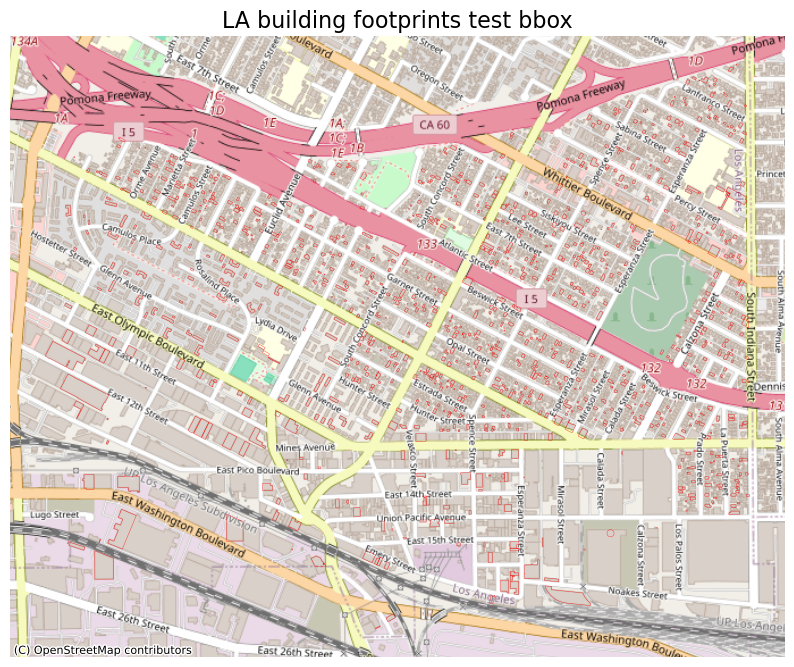

In [10]:
fig, ax = plt.subplots(figsize=(10, 10))

gdf_buildings_3857.plot(
    ax=ax,
    facecolor="none",
    edgecolor="red",
    linewidth=0.3,
    alpha=0.8
)

# Add basemap 
ctx.add_basemap(ax, source=ctx.providers.OpenStreetMap.Mapnik)

# Add title
plt.title("LA building footprints test bbox", fontsize=16)
plt.axis('off')  # optional: remove axis ticks

#Save as PNG
plt.savefig("LA_bldg_test_bbox.png", dpi=300, bbox_inches='tight')  # high-resolution
plt.show()

In [12]:
#Identify any OBJECTID gaps

import numpy as np

# Extract OBJECTIDs as a sorted NumPy array
object_ids = (
    gdf_bbox_bldgs["OBJECTID"]
    .dropna()          # safety
    .astype(int)       # ensure numeric
    .sort_values()     # CRITICAL
    .to_numpy()
)

# Find gaps
gaps = object_ids[1:] - object_ids[:-1]
gap_indices = np.where(gaps > 1)[0]

# Print gaps
for idx in gap_indices:
    start = object_ids[idx]
    end = object_ids[idx + 1]
    print(f"Gap: {start} → {end} (missing {end - start - 1} IDs)")

print(f"Total number of gaps: {len(gap_indices)}")

Total number of gaps: 0


In [13]:
import requests
import geopandas as gpd

def query_bbox_paginated(
    base_url,
    bbox,
    batch_size=1000,
    max_batches=None
):
    all_features = []
    offset = 0
    batch_num = 0

    while True:
        params = {
            "where": "1=1",
            "outFields": "*",
            "geometry": ",".join(map(str, bbox)),
            "geometryType": "esriGeometryEnvelope",
            "spatialRel": "esriSpatialRelIntersects",
            "inSR": 4326,
            "outSR": 4326,
            "f": "geojson",
            "resultOffset": offset,
            "resultRecordCount": batch_size
        }

        r = requests.get(base_url, params=params)
        r.raise_for_status()
        data = r.json()

        features = data.get("features", [])
        n = len(features)

        print(f"Batch {batch_num}: fetched {n} features (offset={offset})")

        if n == 0:
            break

        all_features.extend(features)

        if n < batch_size:
            break

        offset += batch_size
        batch_num += 1

        if max_batches and batch_num >= max_batches:
            print("Stopping early (max_batches reached)")
            break

    return gpd.GeoDataFrame.from_features(all_features, crs="EPSG:4326")


In [14]:
gdf_bbox_bldgs2 = query_bbox_paginated(
    BASE_URL,
    test_bbox,
    batch_size=1000
)

print(len(gdf_bbox_bldgs2))

Batch 0: fetched 1000 features (offset=0)
Batch 1: fetched 1000 features (offset=1000)
Batch 2: fetched 1000 features (offset=2000)
Batch 3: fetched 1000 features (offset=3000)
Batch 4: fetched 1000 features (offset=4000)
Batch 5: fetched 1000 features (offset=5000)
Batch 6: fetched 1000 features (offset=6000)
Batch 7: fetched 1000 features (offset=7000)
Batch 8: fetched 1000 features (offset=8000)
Batch 9: fetched 1000 features (offset=9000)
Batch 10: fetched 1000 features (offset=10000)
Batch 11: fetched 1000 features (offset=11000)
Batch 12: fetched 1000 features (offset=12000)
Batch 13: fetched 1000 features (offset=13000)
Batch 14: fetched 1000 features (offset=14000)
Batch 15: fetched 1000 features (offset=15000)
Batch 16: fetched 1000 features (offset=16000)
Batch 17: fetched 1000 features (offset=17000)
Batch 18: fetched 1000 features (offset=18000)
Batch 19: fetched 1000 features (offset=19000)
Batch 20: fetched 1000 features (offset=20000)
Batch 21: fetched 1000 features (off

In [16]:
gdf_bbox_bldgs2.geometry.head()

0    POLYGON ((-118.21643 34.01526, -118.21714 34.0...
1    POLYGON ((-118.21122 34.02541, -118.21124 34.0...
2    POLYGON ((-118.20368 34.0228, -118.20364 34.02...
3    POLYGON ((-118.1931 34.02172, -118.19314 34.02...
4    POLYGON ((-118.19373 34.01718, -118.19374 34.0...
Name: geometry, dtype: geometry

In [17]:
# Save gdf as geopackage
output_path = "data/LA_buildings_test_full_bbox.gpkg"

gdf_bbox_bldgs2.to_file(
    output_path,
    layer="buildings",
    driver="GPKG"
)

In [18]:
# Map data

#import matplotlib.pyplot as plt
#import contextily as ctx


#Convert to Web Mercator 
gdf_buildings_3857 = gdf_bbox_bldgs2.to_crs(epsg=3857)

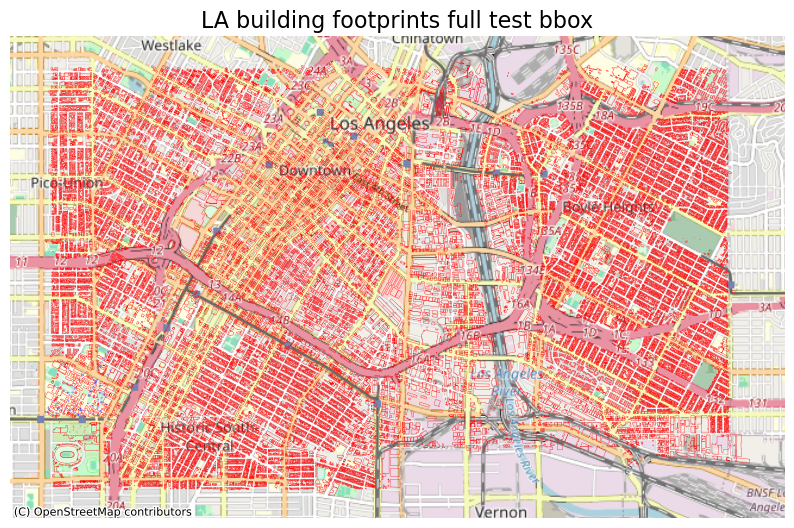

In [19]:
fig, ax = plt.subplots(figsize=(10, 10))

gdf_buildings_3857.plot(
    ax=ax,
    facecolor="none",
    edgecolor="red",
    linewidth=0.3,
    alpha=0.8
)

# Add basemap 
ctx.add_basemap(ax, source=ctx.providers.OpenStreetMap.Mapnik)

# Add title
plt.title("LA building footprints full test bbox", fontsize=16)
plt.axis('off')  # optional: remove axis ticks

#Save as PNG
plt.savefig("LA_bldg_test_full_bbox.png", dpi=300, bbox_inches='tight')  # high-resolution
plt.show()

In [20]:
#import geopandas as gpd

# Load zoning data
gdf_zoning = gpd.read_file("data/commercial_industrial/LAcity_zoning_commercial_industrial_2026_01_14.geojson")

In [21]:
gdf_zoning.head(5)

shape_len     shape_area    zone_cmplt  \
0  159.922768275  1312.05371094   (Q)C1-1-RIO   
1  350.015357513  6250.59765625       (Q)C1-1   
2  520.388311341  10549.9658203       (Q)C1-1   
3  1982.57657975  166992.069336  C1-1-SN-CPIO   
4  1055.10329404  54536.6044922     (Q)C1-1XL   

                                            the_geom zone_category  \
0  { "type": "MultiPolygon", "coordinates": [ [ [...    Commercial   
1  { "type": "MultiPolygon", "coordinates": [ [ [...    Commercial   
2  { "type": "MultiPolygon", "coordinates": [ [ [...    Commercial   
3  { "type": "MultiPolygon", "coordinates": [ [ [...    Commercial   
4  { "type": "MultiPolygon", "coordinates": [ [ [...    Commercial   

                                            geometry  
0  MULTIPOLYGON (((-13187624.404 4050328.287, -13...  
1  MULTIPOLYGON (((-13202128.823 4051267.131, -13...  
2  MULTIPOLYGON (((-13180253.346 4059442.109, -13...  
3  MULTIPOLYGON (((-13188737.364 4069300.941, -13...  
4  MULTIPOLYGON (((-13187078.869 4072134.178, -13...

In [22]:
gdf_zoning.crs

<Projected CRS: EPSG:3857>
Name: WGS 84 / Pseudo-Mercator
Axis Info [cartesian]:
- X[east]: Easting (metre)
- Y[north]: Northing (metre)
Area of Use:
- name: World between 85.06°S and 85.06°N.
- bounds: (-180.0, -85.06, 180.0, 85.06)
Coordinate Operation:
- name: Popular Visualisation Pseudo-Mercator
- method: Popular Visualisation Pseudo Mercator
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [23]:
# Show columns for buildings
print("Building footprints columns:")
print(gdf_buildings_3857.columns.tolist())

print("\n----------------------------------\n")

# Show columns for zoning (already filtered to commercial/industrial)
print("Zoning columns:")
print(gdf_zoning.columns.tolist())

Building footprints columns:
['geometry', 'OBJECTID', 'CODE', 'BLD_ID', 'HEIGHT', 'ELEV', 'SOURCE', 'DATE_', 'STATUS', 'AREA', 'TOOLTIP', 'ID']

----------------------------------

Zoning columns:
['shape_len', 'shape_area', 'zone_cmplt', 'the_geom', 'zone_category', 'geometry']


In [24]:
gdf_bldgs_zoned = gpd.sjoin(
    gdf_buildings_3857,
    gdf_zoning[['zone_category', 'zone_cmplt', 'geometry']],
    how='inner',
    predicate='within'
)


In [25]:
print("Joined GeoDataFrame columns:")
print(gdf_bldgs_zoned.columns.tolist())

print("\nNumber of buildings after zoning filter:")
print(len(gdf_bldgs_zoned))

Joined GeoDataFrame columns:
['geometry', 'OBJECTID', 'CODE', 'BLD_ID', 'HEIGHT', 'ELEV', 'SOURCE', 'DATE_', 'STATUS', 'AREA', 'TOOLTIP', 'ID', 'index_right', 'zone_category', 'zone_cmplt']

Number of buildings after zoning filter:
5913


In [26]:
# Save data as geopackage

output_path = "data/commercial_industrial/buildings_comm_industrial_full_test_bbox.gpkg"

gdf_bldgs_zoned.to_file(
    output_path,
    layer="buildings_comm_industrial",
    driver="GPKG"
)

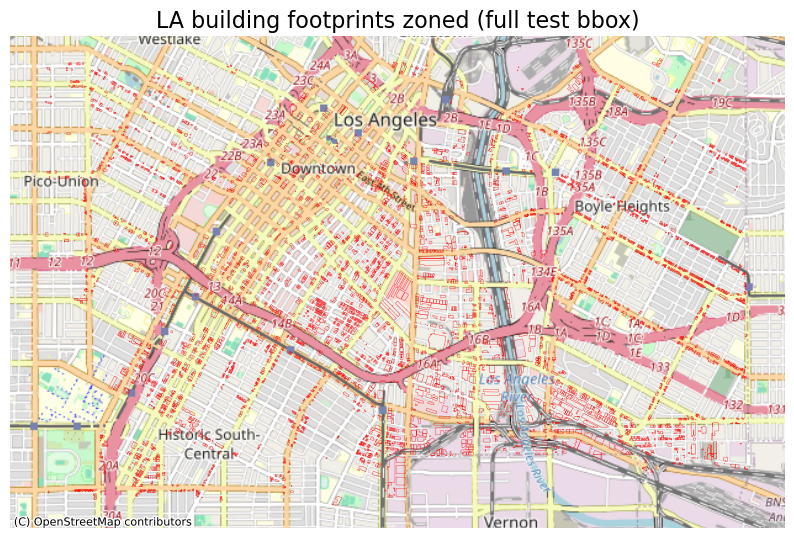

In [27]:
fig, ax = plt.subplots(figsize=(10, 10))

gdf_bldgs_zoned.plot(
    ax=ax,
    facecolor="none",
    edgecolor="red",
    linewidth=0.3,
    alpha=0.8
)

# Add basemap 
ctx.add_basemap(ax, source=ctx.providers.OpenStreetMap.Mapnik)

# Add title
plt.title("LA building footprints zoned (full test bbox)", fontsize=16)
plt.axis('off')  # optional: remove axis ticks

#Save as PNG
plt.savefig("comm_ind_LA_bldg_full_test_bbox.png", dpi=300, bbox_inches='tight')  # high-resolution
plt.show()

In [28]:
print(gdf_bldgs_zoned['AREA'].head(10))
print(gdf_bldgs_zoned['AREA'].describe())


2      111.503613
27    2506.764425
47     574.553765
49    5950.776465
56    7297.956778
59    1183.267842
61     206.728839
62    4942.109457
63     874.244149
74     865.491614
Name: AREA, dtype: float64
count      5913.000000
mean       5676.004299
std       14269.581109
min           4.396498
25%         769.411536
50%        2095.098770
75%        5332.279565
max      415314.610109
Name: AREA, dtype: float64


In [29]:
sqft_threshold = 10000
sqm_threshold = sqft_threshold * 0.092903  # 10,000 sq ft → ~929 m²

In [30]:
gdf_bldgs_large = gdf_bldgs_zoned[gdf_bldgs_zoned['AREA'] > sqm_threshold]

print("Number of buildings >10,000 sqft (~929 m²):", len(gdf_bldgs_large))
gdf_bldgs_large[['OBJECTID', 'AREA', 'zone_category']].head()

Number of buildings >10,000 sqft (~929 m²): 4241


OBJECTID         AREA zone_category
27     77613  2506.764425    Industrial
49     77635  5950.776465    Industrial
56     77642  7297.956778    Industrial
59     77645  1183.267842    Commercial
62     77648  4942.109457    Industrial

In [32]:
# Save data as geopackage

output_path = "data/commercial_industrial/large_buildings_comm_industrial_full_test_bbox.gpkg"

gdf_bldgs_large.to_file(
    output_path,
    layer="buildings_comm_industrial",
    driver="GPKG"
)

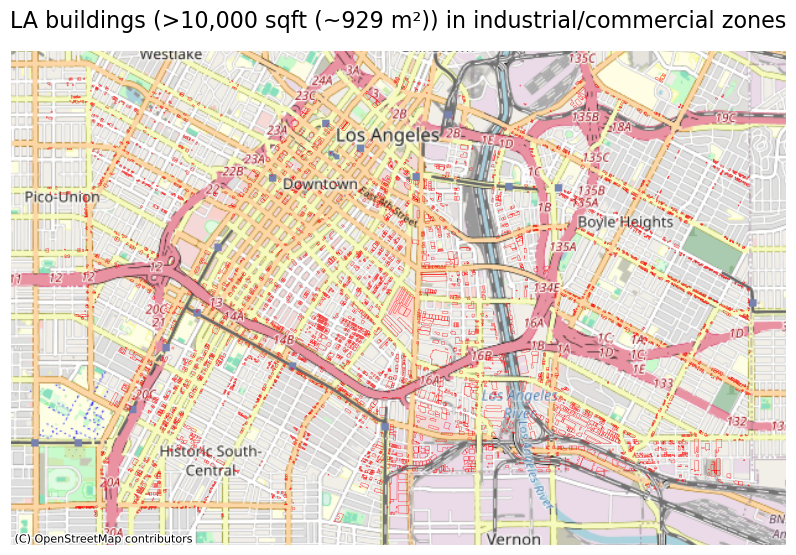

In [33]:
fig, ax = plt.subplots(figsize=(10, 10))

gdf_bldgs_large.plot(
    ax=ax,
    facecolor="none",
    edgecolor="red",
    linewidth=0.3,
    alpha=0.8
)

# Add basemap 
ctx.add_basemap(ax, source=ctx.providers.OpenStreetMap.Mapnik)

# Add title
plt.title("LA buildings (>10,000 sqft (~929 m²)) in industrial/commercial zones", fontsize=16)
plt.axis('off')  # optional: remove axis ticks

#Save as PNG
plt.savefig("large_comm_ind_LA_bldg_full_test_bbox.png", dpi=300, bbox_inches='tight')  # high-resolution
plt.show()